# Project: Recommending Artists based on previous listenings


## Import Packages


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 10.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617625 sha256=425a7e2e04a65394bd22cbfc3818e17935e48f3c765951d5acc6a9210b843e57
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/wm-project/"
%cd /content/drive/My\ Drive/wm-project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
02062021MusicRecommenderTeam3.ipynb
26052021MusicRecommenderTeam3.ipynb
all_predictions_scores.csv
als_predictions_scores1.csv
als_predictions_scores2.csv
als_predictions_scores.csv
back22052021MusicRecommenderTeam3.ipynb
df_artist.csv
df_general.csv
df_outlierDtected.csv
df_preprocessed.csv
df_test.csv
df_train_cleaned.csv
df_train_to_explore.csv
lookup_artist_names.csv
MusicRecommender_01_Preprocessing_backup.ipynb
MusicRecommender_01_Preprocessing.ipynb
MusicRecommender_02_Modelling.ipynb
nrartist_df.csv
parameter_tuning
rec_train.csv
tasks.gsheet
userid-profile.tsv
userid-timestamp-artid-artname-traid-traname.tsv
WM_Slides_08062021.pptx
/content/drive/My Drive/wm-project


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import hashlib
import pytz
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import csr_matrix
from surprise import SVD, NMF, KNNBasic, KNNWithMeans,Reader,Dataset
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import ndcg_score

In [ ]:
# Create Profile Dataframe

df_profile = pd.read_csv(
    'userid-profile.tsv',
    sep='\t',
    header=0,
    names=['user_id', 'gender', 'age', 'country', 'registered']
)
#convert register to DateTime in a new column
df_profile['registered_asDate'] = pd.to_datetime(df_profile['registered'],infer_datetime_format=True)
df_profile = df_profile.drop(columns='registered')
df_profile.head(3)

,user_id,gender,age,country,registered_asDate
0,user_000001,m,NaN,Japan,2006-08-13
1,user_000002,f,NaN,Peru,2006-02-24
2,user_000003,m,22.0,United States,2005-10-30


## Import train and test (02.06)

In [ ]:
trainset = pd.read_csv('df_train_cleaned.csv')
testset = pd.read_csv('df_test.csv')

In [ ]:
#check duplicates
pd.concat(g for _, g in trainset.groupby(['user_id', 'artist_id']) if len(g) > 1)
pd.concat(g for _, g in testset.groupby(['user_id', 'artist_id']) if len(g) > 1)

,user_id,artist_id,absolute
77722,user_000004,def226b0-7990-4b38-ab1a-7740461844dc,9
166119,user_000004,def226b0-7990-4b38-ab1a-7740461844dc,9
83814,user_000006,7b290da1-03f2-4d91-8f6e-0e4930e39831,20
115152,user_000006,7b290da1-03f2-4d91-8f6e-0e4930e39831,20
112192,user_000125,45b3b313-0ec2-455b-b2fb-858bb4faac10,9
146814,user_000125,45b3b313-0ec2-455b-b2fb-858bb4faac10,9
16457,user_000177,e5257dc5-1edd-4fca-b7e6-1158e00522c8,3
96244,user_000177,e5257dc5-1edd-4fca-b7e6-1158e00522c8,3
73907,user_000296,ebe02d36-410d-4a85-a67e-36e2462e3e44,2
112988,user_000296,ebe02d36-410d-4a85-a67e-36e2462e3e44,2


In [ ]:
trainset = trainset.drop_duplicates() # 992 users
testset = testset.drop_duplicates() # 990 users

In [ ]:
#add relative counts
testset['user_total'] = testset.groupby('user_id').absolute.transform('sum')
testset['relative'] = testset['absolute'] / testset['user_total']
testset.drop(columns=['user_total'], inplace=True)

# Recommender System

Recommending new artists based on users collaborative filtering on the frequency of their listenings to each artist

## Import lookup tables

In [ ]:
# CSV imports
lookup_artist_names = pd.read_csv('lookup_artist_names.csv')

## Popularity Based Recommender (Non-personalized)

In [ ]:
def unpersonalized_popularity(pred_df, num_recommendations):
  # Calculate popularity
  df_popularity = pred_df.copy()
  df_popularity.drop(axis=1, columns=['user_id'], inplace=True)
  df_popularity['total'] = df_popularity.groupby(['artist_id'])['absolute'].transform('sum')
  df_popularity.drop_duplicates(subset=['artist_id'], keep='first', inplace=True)

  # sort and return top artists
  df_popularity.sort_values(by=['total'], ascending=False, inplace=True)
  df_popularity.reset_index(drop=True, inplace=True)
  df_popularity.drop(axis=1, 
                 columns=['absolute', 'relative', 'total', 'user_total'],
                 inplace=True)
  return df_popularity.head(num_recommendations)

In [ ]:
#print(unpersonalized_popularity(trainset, 10))

## Popularity Based Recommender (Personalized)

In [ ]:
def popularity_artist_user(pred_df, this_user, num_recommendations):
  
  # Get listened artists
  df_listened = pred_df.loc[pred_df['user_id'] == this_user].copy()
  df_listened.drop(axis=1, columns=['user_id'], inplace=True)
  df_listened.drop_duplicates(subset=['artist_id'], keep='first', inplace=True)
  df_listened['total'] = 1
  
  # Calculate popularity
  df_popularity = pred_df.copy()
  df_popularity.drop(axis=1, columns=['user_id'], inplace=True)
  df_popularity['total'] = df_popularity.groupby(['artist_id'])['absolute'].transform('sum')
  df_popularity.drop_duplicates(subset=['artist_id'], keep='first', inplace=True)

  # Remove listened songs
  result_df = pd.concat([df_popularity, df_listened])
  result_df.drop_duplicates(subset=['artist_id'], keep=False, inplace=True)
  

  # sort and return top artists
  result_df.sort_values(by=['total'], ascending=False, inplace=True)
  result_df.reset_index(drop=True, inplace=True)
  result_df.drop(axis=1, 
                 columns=['absolute', 'relative', 'total', 'user_total'],
                 inplace=True)
  return result_df.head(num_recommendations)

In [ ]:
trainset[(trainset['user_id']=='user_000658')&(trainset['artist_id']=='cc197bad-dc9c-440d-a5b5-d52ba2e14234')]

,user_id,artist_id,absolute,user_total,relative,log,log_relative


In [ ]:
popularity_artist_user(trainset,'user_000658',10)

,artist_id
0,b7ffd2af-418f-4be2-bdd1-22f8b48613da
1,cc197bad-dc9c-440d-a5b5-d52ba2e14234
2,8538e728-ca0b-4321-b7e5-cff6565dd4c0
3,03ad1736-b7c9-412a-b442-82536d63a5c4
4,83d91898-7763-47d7-b03b-b92132375c47
5,5441c29d-3602-4898-b1a1-b77fa23b8e50
6,95e1ead9-4d31-4808-a7ac-32c3614c116b
7,69ee3720-a7cb-4402-b48d-a02c366f2bcf
8,40f5d9e4-2de7-4f2d-ad41-e31a9a9fea27
9,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab


## CF User-based and Item-based Artist Recommender

@author NR

In [ ]:
df_matrix = trainset.pivot(index = 'artist_id', columns ='user_id', values = 'relative').fillna(0)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_matrix.T, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print('Shape of User Similarity Matrix:', user_correlation.shape)
print(user_correlation)
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_matrix, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print('Shape of Item Similarity Matrix:', item_correlation.shape)


Shape of User Similarity Matrix: (992, 992)
[[1.         0.00231315 0.00113522 ... 0.00130053 0.00166652 0.00131726]
 [0.00231315 1.         0.04568325 ... 0.19017793 0.05908118 0.08458703]
 [0.00113522 0.04568325 1.         ... 0.06973466 0.03672582 0.05369282]
 ...
 [0.00130053 0.19017793 0.06973466 ... 1.         0.17273318 0.26578226]
 [0.00166652 0.05908118 0.03672582 ... 0.17273318 1.         0.02742821]
 [0.00131726 0.08458703 0.05369282 ... 0.26578226 0.02742821 1.        ]]
Shape of Item Similarity Matrix: (10335, 10335)


In [ ]:
def predict(freq, similarity, type='user'):
    if type == 'user':
        mean_user_freq = freq.mean(axis=1)
        
        freq_diff = (freq - mean_user_freq[:, np.newaxis])
        pred = mean_user_freq[:, np.newaxis] + similarity.dot(freq_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        
    elif type == 'item':
        mean_item_freq = freq.mean(axis=0)
        freq_diff = (freq - mean_item_freq[np.newaxis, :])
        
        pred = mean_item_freq[np.newaxis, :] + freq_diff.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

    return pred.clip(0)

In [ ]:
artist_list = pd.DataFrame(trainset['artist_id'].unique(),columns=['artist_id'])

In [ ]:
user_prediction = predict(df_matrix.T, user_correlation, type='user')
item_prediction = predict(df_matrix.T, item_correlation, type='item')
item_pred_df = pd.DataFrame(item_prediction)
user_pred_df= pd.DataFrame(user_prediction , index=df_matrix.columns, columns=df_matrix.T.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  C

In [ ]:
item_pred_df.columns = df_matrix.T.columns

In [ ]:
def CF_recommend_newArtist(pred_df, user_id, num_recommendations,method_name):

    sorted_user_predictions = pred_df.loc[user_id].sort_values(ascending=False) 
    user_alreadyListened = trainset[trainset['user_id'] == user_id]

    newArtists = artist_list[~artist_list['artist_id'].isin(set(user_alreadyListened['artist_id']))]
    recommendations = (newArtists.
        
         merge(pd.DataFrame(sorted_user_predictions), how = 'left',
               left_on = 'artist_id',
               right_on = 'artist_id').
         rename(columns = {user_id: method_name}).
         sort_values(method_name, ascending = False).
                       iloc[:num_recommendations, :]
                      )
    return recommendations

In [ ]:
recommendations = CF_recommend_newArtist(item_pred_df, 'user_000604', 10, 'CF_item_pred_freq')
recommendations

,artist_id,CF_item_pred_freq
113,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,0.005983
9019,0fb04a47-2c27-4598-9fbc-b90ac573cb97,0.005122
1006,9c9f1380-2516-4fc9-a3e6-f9f61941d090,0.003948
494,b7ffd2af-418f-4be2-bdd1-22f8b48613da,0.003764
4164,f940c4dd-f687-4c6a-872b-1cce3f78dc0a,0.003624
4185,e2e296c5-2318-4be9-8002-a3352c37c5e5,0.003417
153,bb110dbc-8daa-407f-a04b-f569e7a5ee7e,0.003271
281,39ab1aed-75e0-4140-bd47-540276886b60,0.003252
7446,53e6200c-a7f7-4513-9360-39b3db391053,0.003196
317,69ee3720-a7cb-4402-b48d-a02c366f2bcf,0.003144


In [ ]:
recommendations = CF_recommend_newArtist(user_pred_df, 'user_000072', 10, 'CF_user_pred_freq')
recommendations

,artist_id,CF_user_pred_freq
411,95e1ead9-4d31-4808-a7ac-32c3614c116b,0.005255
121,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,0.004731
53,aa7a2827-f74b-473c-bd79-03d065835cf7,0.004011
135,03ad1736-b7c9-412a-b442-82536d63a5c4,0.003601
104,83d91898-7763-47d7-b03b-b92132375c47,0.003590
463,847e8284-8582-4b0e-9c26-b042a4f49e57,0.003565
213,8bfac288-ccc5-448d-9573-c33ea2aa5c30,0.003555
179,8538e728-ca0b-4321-b7e5-cff6565dd4c0,0.003456
77,cb67438a-7f50-4f2b-a6f1-2bb2729fd538,0.003347
124,b23e8a63-8f47-4882-b55b-df2c92ef400e,0.003313


## Surprise KNN Recommender


In [ ]:
trainset_ = trainset.drop(columns=['absolute', 'user_total'])


In [ ]:
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, SVD, accuracy, SVDpp, KNNWithMeans

## Load the data into surprise input data format

reader = Reader(line_format= 'user item rating',rating_scale=(0, 1))

trainset_.index = range(len(trainset_)) 
trainset_.index = range(len(trainset_)) 
trainsetCopy = trainset_
trainset_mf = Dataset.load_from_df(trainset_, reader)


### Hyperparameter optimization

### Surprise KNN-Recommender with optimized hyperparameters


In [ ]:
sim_option_item = {'name': 'cosine',
              'user_based': False  
               }

In [ ]:
# implement the model based on parameters from KNN_grid_search_hyperparameter_tuning.ipynb

trainset_mf = trainset_mf.build_full_trainset()
algorithm = KNNWithMeans(k=60, min_k=1, sim_options=sim_option_item)
model_nmf = algorithm.fit(trainset_mf)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# function for recommendation

def pred_user_rating(thisUserId, headLength):
    if thisUserId in trainsetCopy.user_id.unique():
        # Make list of all artists in train set
        list_all = trainsetCopy.artist_id.unique().tolist()
        # Make list of artists that appear for this user in train set
        list_listened = trainsetCopy[trainsetCopy.user_id == thisUserId].artist_id.unique().tolist()
        # Make list of new artists for this user (based on training set listening)
        list_final = [x for x in list_all if x not in list_listened]

        # iterate and make predictions
        predictedL = []
        for thisArtistId in list_final:     
            predicted = algorithm.predict(thisUserId, thisArtistId)
            
            predictedL.append((thisArtistId, predicted[3]))
            
            

        # create sorted dataframe
        predictions_df = pd.DataFrame(predictedL, 
                                      columns = ['artist_id', 'pred_freq'])
        predictions_df.sort_values('pred_freq', 
                                   ascending=False, 
                                   inplace=True)  
        predictions_df.set_index('artist_id',
                                 inplace=True)

        return predictions_df.head(headLength)        
    else:
        print("User ID does not exist in the train set!")
        return None

In [ ]:
def knn_recommend_artists(user,n=10):
  rec_artists = pred_user_rating(user, n)
  return rec_artists.head(n).index.values.tolist()


In [ ]:
knn_recommend_artists('user_000072',10)

['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42',
 '7882e4c9-8bed-487d-955b-4ae388472339',
 'd9d04200-fc85-4c5f-8e0d-4b3ea4939d8f',
 '6a1ed603-a7af-435c-afac-f221f98b953c',
 '66534b52-943e-47ac-976a-a6bb3e03227a',
 '4500926c-bbbf-4940-bdd3-829f38ba950d',
 'e5d8c705-8ea4-4820-b11d-fbf580d85ce4',
 'dba65a44-ea8f-47d4-b0bb-e42aefc33498',
 'bcbd5e84-9e9f-42d4-ae0f-836e11707e1b',
 'bcc9d0d3-22e2-4b53-959a-86e200555b84']

## Implicit

###LightFM

In [ ]:
trainset.head()

,user_id,artist_id,absolute,user_total,relative,log,log_relative
0,user_000774,7acc6c97-2654-4ffa-945f-daeabaa8e5ae,19,38970,0.000488,2.995732,0.397134
1,user_000770,65314b12-0e08-43fa-ba33-baaa7b874c15,127,17154,0.007404,4.852030,2.128651
2,user_000646,3e30aebd-0557-4cfd-8fb9-3945afa5d72b,8,1211,0.006606,2.197225,2.028952
3,user_000658,a74b1b7f-71a5-4011-9441-d0b5e4122711,507,8052,0.062966,6.230481,4.158347
4,user_000772,42995787-59e7-46fa-9d4f-d9bb68d27521,842,15370,0.054782,6.736967,4.021452


In [ ]:
df_artist = trainset.drop(columns=['absolute', 'log', 'log_relative'])
df_artist.head()

,user_id,artist_id,user_total,relative
0,user_000774,7acc6c97-2654-4ffa-945f-daeabaa8e5ae,38970,0.000488
1,user_000770,65314b12-0e08-43fa-ba33-baaa7b874c15,17154,0.007404
2,user_000646,3e30aebd-0557-4cfd-8fb9-3945afa5d72b,1211,0.006606
3,user_000658,a74b1b7f-71a5-4011-9441-d0b5e4122711,8052,0.062966
4,user_000772,42995787-59e7-46fa-9d4f-d9bb68d27521,15370,0.054782


In [ ]:
user_to_id = dict(zip(df_profile['user_id'], range(len(df_profile['user_id']))))

In [ ]:
for i,row in df_profile.iterrows():
  
  df_profile.loc[i,'userID']=user_to_id[df_profile.loc[i, 'user_id']]

In [ ]:
df_artist['userID']=df_artist['user_id'].map(user_to_id)

In [ ]:
 df_artist['userID']=df_artist['userID'].astype(np.int32)
 df_profile['userID']=df_profile['userID'].astype(np.int32)

In [ ]:
df_artist.head()

,user_id,artist_id,user_total,relative,userID
0,user_000774,7acc6c97-2654-4ffa-945f-daeabaa8e5ae,38970,0.000488,766
1,user_000770,65314b12-0e08-43fa-ba33-baaa7b874c15,17154,0.007404,762
2,user_000646,3e30aebd-0557-4cfd-8fb9-3945afa5d72b,1211,0.006606,639
3,user_000658,a74b1b7f-71a5-4011-9441-d0b5e4122711,8052,0.062966,651
4,user_000772,42995787-59e7-46fa-9d4f-d9bb68d27521,15370,0.054782,764


In [ ]:
!pip install lightfm

     |████████████████████████████████| 317kB 8.3MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=706121 sha256=c4361651262d0cf62b9afd99f6c60184d6fee32ffff73382fcb7cb7377e536c4
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [ ]:

# dummify categorical features
user_profile_transformed = pd.get_dummies(df_profile[['userID','gender','country']], columns = ['gender','country'])

#user_profile_transformed = user_profile_transformed.sort_values('userID').reset_index().drop('index', axis=1)
user_profile_transformed.head(5)

,userID,gender_f,gender_m,country_Algeria,country_Antarctica,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Belarus,country_Belgium,country_Bosnia and Herzegovina,country_Brazil,country_British Indian Ocean Territory,country_Bulgaria,country_Canada,country_Chile,country_China,country_Colombia,"country_Congo, the Democratic Republic of the",country_Cote D'Ivoire,country_Croatia,country_Czech Republic,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Iceland,country_India,country_Ireland,country_Israel,country_Italy,country_Japan,"country_Korea, Democratic People's Republic of",country_Latvia,country_Lithuania,country_Macedonia,country_Malta,country_Mexico,country_Morocco,country_Netherlands,country_Netherlands Antilles,country_New Zealand,country_Nicaragua,country_Northern Mariana Islands,country_Norway,country_Peru,country_Poland,country_Portugal,country_Romania,country_Russian Federation,country_Serbia,country_Singapore,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_United Kingdom,country_United States,country_United States Minor Outlying Islands,country_Venezuela,country_Zimbabwe
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_metadata_csr = csr_matrix(user_profile_transformed.drop('userID', axis=1).values)
user_metadata_csr

<992x68 sparse matrix of type '<class 'numpy.uint8'>'
	with 1791 stored elements in Compressed Sparse Row format>

In [ ]:
#features=np.identity(df_artist['artist_id'].unique().shape[0])
#features_crs=csr_matrix(features)

In [ ]:
train_interaction = pd.pivot_table(df_artist, index='userID', columns='artist_id', values='relative')

In [ ]:
train_interaction = train_interaction.fillna(0)

train_interaction.head(5)

artist_id,0004537a-4b12-43eb-a023-04009e738d2e,00090329-61b1-4754-bf30-88829efaa51f,000b1990-4dd8-4835-abcd-bb6038c13ac7,000d90ec-d64c-48a1-b775-e726fd240e9f,000fc734-b7e1-4a01-92d1-f544261b43f5,000fecd9-ae03-49bc-9a08-636dde5d405d,0019749d-ee29-4a5f-ab17-6bfa11deb969,001ce2d7-c045-4343-b703-a4fc7dcee0a6,00330ad2-6d94-4957-b3b0-7ca1ea6f6fd6,00370693-7679-46c1-8ddd-63e1d082c459,0038bcbd-5f12-4a05-9f77-324652334345,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,003c6719-4f2e-4b89-8427-3068460e8367,00467da8-2a92-498f-8b10-a80889bcded7,004697a7-e86c-41cf-bed3-49494287b164,004913ca-cc81-44ca-b1b5-6f82149cf475,004e5eed-e267-46ea-b504-54526f1f377d,0051db34-6ac5-4e73-ae8e-b11d3a7746b8,0053dbd9-bfbc-4e38-9f08-66a27d914c38,00565b31-14a3-4913-bd22-385eb40dd13c,005bc8ce-7abb-4552-8472-7f7368f099f9,0065f4cc-cf21-43c2-ad52-92716a579547,006f0783-c5a0-458b-a9da-f8551f7ebe77,00764bd8-9974-412e-a374-1915c31f0070,007a084b-f435-4d78-be2a-3f9dd552ebc9,007c3959-6ad5-4ced-bbaf-fbf4f38dbb0a,007dbf51-6ee0-4038-8e90-94a954e25ca3,00950dec-8f3a-4a17-9717-e7872a954d8b,0096e98d-7dc7-437a-957a-6719ff1a0f20,00999cc8-8305-47d6-876d-b4165a0522cb,009a44cd-e5b7-4b0f-beee-64391f8e93fd,009d1a78-80cb-4399-9bd4-b13d5e15a968,00a8bf3d-acbc-4e17-8e07-ab5d3ae550e8,00a9f935-ba93-4fc8-a33a-993abe9c936b,00b0a363-2fbc-4af7-b67d-70cf035829e7,00b952be-6c97-4880-84f9-06de584b491b,00c49f40-d715-4b79-b223-432048602cce,00ce2ec6-5ccb-4dc3-ac89-08779926d2b3,00cf472e-7868-4343-ad2c-92dd13261d43,00dbf694-d614-44cc-91d3-21bf18800e3d,...,ff5847df-4ef3-4145-8380-5ec124ce2d20,ff693144-69be-4ec5-9150-cb3c5652e430,ff6b03b8-116b-4a15-9185-0630a15e7b75,ff6e677f-91dd-4986-a174-8db0474b1799,ff711332-b409-44dd-ad1d-f7714f8906db,ff7466a5-c538-4d2b-8450-54f11b20f2f4,ff748426-8873-4725-bdc7-c2b18b510d41,ff788be9-e7e3-45c5-86de-942a9b24a8c5,ff7f80cd-05c2-4068-a00e-fbfbd453d049,ff865aa0-4603-4f79-ae8b-8735332e2cfa,ff8b7188-b255-4074-8074-d985452c8e51,ff9542ca-7859-4db2-8796-c1e3c39b9c0a,ff95eb47-41c4-4f7f-a104-cdc30f02e872,ff9c106f-e342-4543-a376-776e08121f69,ff9deaae-da4f-42b7-a19e-36fedd3fc706,ff9ef2ef-73a6-496c-8528-4b12b21afbfd,ffa18b18-81ee-474c-aae2-df70b406a069,ffa25bb8-a082-4b47-aa4c-9ef48df98dc6,ffa28514-93f0-402b-860c-78b3c675cf3b,ffa28768-ecda-42c6-ac49-6ce5c7d33043,ffa93e03-f6c5-4d78-b0d5-07d0d6de46aa,ffaad848-b461-4411-afa7-94987106926b,ffaff287-8849-465a-81f4-501a49eafd42,ffb18e19-64a4-4a65-b4ce-979e00c3c69d,ffb2d3e3-a4cc-48cf-8fb0-f2f846e9d7b9,ffb390b8-8df4-4b72-97d1-7b2fc008a452,ffb45501-b01c-443a-8cc4-6d80c9c13545,ffb89363-2a3c-4b70-bf85-18782dba5b11,ffba0d4b-a2bd-46d1-98e0-bf7d08ae8744,ffbaa76f-a071-4647-95b9-b79774e8bf9d,ffbf53ef-3afc-45b5-a664-66587ed9ea44,ffc35dde-fc40-4009-bb41-a9aedfd2a27c,ffcf39e8-57ad-4e06-987b-d178b7fe34f5,ffd3ac37-4d0a-42a1-a41e-e160cf60dca5,ffd7d8c2-21f3-4f29-ba4e-66d9246f4ce7,ffe02aed-ef7e-4736-a186-c2f1dd55ce8d,ffe16bba-4d84-409b-8f22-5242c60b930f,ffe53025-23f7-4c80-ac9d-442a3275d4a6,ffe8acdb-3fa3-4f7e-8939-c3862138502d,ffe9ec08-6b6b-4993-9394-e280b429dbfd
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000756,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023206,0.0,0.0,0.0,0.0,0.0,0.0,0.000243,0.0,0.0,0.0,0.000297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000513,0.0,0.0,0.0,0.0,0.002402,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002186,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
train_interaction_csr = csr_matrix(train_interaction.values)

In [ ]:
# parameters based on LightFM_random_search_hyperparameter_tuning.ipynb
model = LightFM(loss='warp',
                random_state = 2021,
                learning_rate = 0.01846728530000181,
                learning_schedule='adagrad',
                no_components = 40
                )

model_lmf = model.fit(train_interaction_csr,
                  user_features=user_metadata_csr,
                  #item_features=features_crs,
                  epochs = 84,
                  num_threads = 16, verbose = False)

In [ ]:
def lightfm_artist_recommendation(model, interactions, user_id, user_dict, showKnown, 
                               threshold = 0,nrec_items = 10):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items),
                                     #item_features=features_crs,
                                     user_features=user_metadata_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_x,:] \
                                 [interactions.loc[user_x,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items))
    scores = list(pd.Series(return_score_list))
    if showKnown == True:
        # print ("User: " + str(user_id))
        # print("Known Likes:")
        counter = 1
        for i in known_items:
            # print(str(counter) + '- ' + str(i))
            counter+=1

    # print("\n Recommended Artists:")
    counter = 1
    imp_recs = []
    for i in scores:
        # print(str(counter) + '- ' + str(i))
        imp_recs.append(str(i))
        counter+=1
    return imp_recs

In [ ]:
lightfm_artist_recommendation(model_lmf, train_interaction, 'user_000604', user_to_id, False)

['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d',
 '7dc8f5bd-9d0b-4087-9f73-dc164950bbd8',
 '9fdaa16b-a6c4-4831-b87c-bc9ca8ce7eaa',
 '9e0e2b01-41db-4008-bd8b-988977d6019a',
 'b071f9fa-14b0-4217-8e97-eb41da73f598',
 '5182c1d9-c7d2-4dad-afa0-ccfeada921a8',
 '75167b8b-44e4-407b-9d35-effe87b223cf',
 '6fe07aa5-fec0-4eca-a456-f29bff451b04',
 '0039c7ae-e1a7-4a7d-9b49-0cbc716821a6',
 '40f5d9e4-2de7-4f2d-ad41-e31a9a9fea27']

###ALS

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 6.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406406 sha256=d6694672e47d93c6245291499842244afbeef5f93e484bbae6ba6f169a8453c9
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
trainset_als = trainset.drop(columns=['relative', 'log', 'log_relative'])

In [ ]:
#for the latest split 01.06

trainset_als['userId'] = trainset_als['user_id'].astype('category').cat.codes
trainset_als['itemId'] = trainset_als['artist_id'].astype('category').cat.codes

import scipy.sparse as sparse
user_items = sparse.csr_matrix((trainset_als['absolute'].astype(float),(trainset_als['userId'], trainset_als['itemId'])))
item_users = sparse.csr_matrix((trainset_als['absolute'].astype(float),(trainset_als['itemId'], trainset_als['userId'])))

In [ ]:
matrix_size = user_items.shape[0]*user_items.shape[1] # Number of possible interactions in the matrix
num_listenings = len(user_items.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_listenings/matrix_size))
sparsity

97.88514209466736

In [ ]:
import implicit


In [ ]:
# parameters based on the result of ALS_Hyperparameter_tuning.ipynb

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.01, iterations=40,use_cg=True,use_gpu=False)

# Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric)

alpha_val = 1
data_conf = (item_users * alpha_val).astype('double')


#Fit the model
model.fit(data_conf)

In [ ]:
def als_recommend(user_id, n=10):
  
  userId=trainset_als.loc[trainset_als.user_id==user_id].iloc[0].userId
  recommended = model.recommend(userId, user_items,N = n,filter_already_liked_items = True)
  artists = []
  scores = []
  for item in recommended:
    idx, score = item
    
    artists.append(trainset_als.loc[trainset_als.itemId == idx].iloc[0].artist_id)
    scores.append(score)
  recommendations = pd.DataFrame({'artist': artists, 'score': scores})
  return artists, scores
  

In [ ]:
als_recommend('user_000604', n=10)

(['44f42386-a733-4b51-8298-fe5c807d03aa',
  'ef2d4a1c-195e-41f4-839e-bdfd3f85adc3',
  'ac865b2e-bba8-4f5a-8756-dd40d5e39f46',
  '606bf117-494f-4864-891f-09d63ff6aa4b',
  '51508c1f-8d07-4a00-9cf1-26c570fe7b78',
  'ae1b47d5-5128-431c-9d30-e08fd90e0767',
  '1c3919b2-43ca-4a4a-935d-9d50135ec0ef',
  '8ac9e35c-e92d-4030-99ef-ba4127b1555c',
  '65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab',
  '20883363-1ea4-4d72-ad72-c0e767038f3e'],
 [1.2672913,
  1.1628515,
  1.1262681,
  1.1188147,
  1.1130575,
  1.0904243,
  1.0863426,
  1.075052,
  1.069509,
  1.0619361])

# Evaluation

The current idea is to get recommendations based on train set. For each user we recommend the most potentially liked artists that has not been observed for that user in train set and later check in test set if the user will listen to the recommended artists.And judge the model performance based on precision and recall.

In [ ]:
!pip install ml_metrics
!pip install funcsigs
!pip install recmetrics

In [ ]:
import recmetrics
#if error occurs:
#ImportError: cannot import name 'signature' from 'sklearn.utils.fixes' (/usr/local/lib/python3.7/dist-packages/sklearn/utils/fixes.py)
#change the plots.py - Instead of 'from sklearn.utils.fixes import signature' use 'from funcsigs import signature'
import ml_metrics as metrics

### save all prediction results 
- don't have to run this section
- all results are in 'all_predictions_scores.csv'

In [ ]:
# prepares the true liked artists from validation set for evaluation.
test = pd.DataFrame(testset, columns=['user_id', 'artist_id', 'relative'])
test = test.groupby('user_id', as_index=False)['artist_id'].agg(
    {'true_artist': (lambda x: list(set(x)))})
#test = test.set_index("user_id")

In [ ]:
test[test.user_id == 'user_000766']

,user_id,true_artist
757,user_000766,"[3b40b4f6-070c-4433-86ff-c57c71046456, eeb1195..."


In [ ]:
# 1min 39s
# store popularity-based recommendations for all users
pop_recs = [] 
k=10
for user in test.user_id:
    #print(user)
    pop_predictions = popularity_artist_user(trainset, user, k).artist_id.values.tolist()
    pop_recs.append(pop_predictions)

test['pop_pred'] = pop_recs

In [ ]:
# XXXXXX
# store unpersonalized popularity-based recommendations for all users

fix_recs = []
k=10
fix_recommendation = unpersonalized_popularity(trainset, k).artist_id.values.tolist()
for user in test.user_id:
    fix_recs.append(fix_recommendation)

test['fix_pred'] = fix_recs

In [ ]:
# 58sec
# store cf recommendations and scores for all users
cf_user_recs = [] 
cf_user_freq = []
cf_item_recs = []
cf_item_freq = []

for user in test.user_id:
    # print(user)
    user_recommendations = CF_recommend_newArtist(user_pred_df, user, 10, 'CF_user_pred_freq')
    cf_user_pred = user_recommendations.artist_id.values.tolist()
    cf_user_pred_freq = user_recommendations.CF_user_pred_freq.values.tolist()
    cf_user_recs.append(cf_user_pred)
    cf_user_freq.append(cf_user_pred_freq)

    item_recommendations = CF_recommend_newArtist(item_pred_df, user, 10, 'CF_item_pred_freq')
    cf_item_pred = item_recommendations.artist_id.values.tolist()
    cf_item_pred_freq = item_recommendations.CF_item_pred_freq.values.tolist()
    cf_item_recs.append(cf_item_pred)
    cf_item_freq.append(cf_item_pred_freq)

test['cf_user_pred'] = cf_user_recs
test['cf_user_pred_freq'] = cf_user_freq
test['cf_item_pred'] = cf_item_recs
test['cf_item_pred_freq'] = cf_item_freq

In [ ]:
#6min
# store mf recommendations for all users
knn_recs = [] 
for user in test.user_id:
    #print(user)
    knn_predictions = knn_recommend_artists(user, n=10)
    knn_recs.append(knn_predictions)

test['knn_pred'] = knn_recs

In [ ]:
#55sec
# store lfm recommendations for all users
lfm_recs = []
for user in test.user_id:
    #print(user)
    lfm_predictions = lightfm_artist_recommendation(model_lmf, train_interaction, user, user_to_id, False)
    lfm_recs.append(lfm_predictions)

test['lfm_pred'] = lfm_recs

In [ ]:
#21sec
# store als recommendations for all users
als_recs = [] 
als_score = []

for user in test.user_id:
    # print(user)
    artistList, scoreList = als_recommend(user, n=10)
    als_recs.append(artistList)
    als_score.append(scoreList)

test['als_recs'] = als_recs
test['als_score'] = als_score

In [ ]:
#3m
# store the true freq of predicted artists from cf user

#create a column of empty lists for true freqs
test['cf_user_true_freq'] = np.empty((len(test), 0)).tolist()

#for each row, save the true freq in the order of predicted artists
for i, row in test.iterrows():
  user = row['user_id']
  test.at[i, 'cf_user_true_freq']= []
  for j in range(len(row['cf_user_pred'])):
    artistId = row['cf_user_pred'][j]
    #if the predicted artists doesn't exist in testset, set the true freq 0.
    if testset.query("user_id==@user&artist_id==@artistId").relative.values.size == 0:
      true=0
    else: 
      true=testset.query("user_id==@user&artist_id==@artistId").relative.values[0]
    test.at[i, 'cf_user_true_freq'].append(true)

In [ ]:
#2m39s
# store the true freq of predicted artists from cf item
test['cf_item_true_freq'] = np.empty((len(test), 0)).tolist()

for i, row in test.iterrows():
  user = row['user_id']
  test.at[i, 'cf_item_true_freq']= []
  for j in range(len(row['cf_item_pred'])):
    artistId = row['cf_item_pred'][j]
    if testset.query("user_id==@user&artist_id==@artistId").relative.values.size == 0:
      true=0
    else: 
      true=testset.query("user_id==@user&artist_id==@artistId").relative.values[0]
    test.at[i, 'cf_item_true_freq'].append(true)

In [ ]:
#2m37s
# store the true freq of predicted artists from als
test['als_true_score'] = np.empty((len(test), 0)).tolist()

for i, row in test.iterrows():
  user = row['user_id']
  test.at[i, 'als_true_score']= []
  for j in range(len(row['als_recs'])):
    artistId = row['als_recs'][j]
    if testset.query("user_id==@user&artist_id==@artistId").relative.values.size == 0:
      true=0
    else: 
      true=testset.query("user_id==@user&artist_id==@artistId").relative.values[0]
    test.at[i, 'als_true_score'].append(true)

In [ ]:
test.to_csv('all_predictions_scores.csv')

### Import Results

In [ ]:
test = pd.read_csv('all_predictions_scores.csv')

In [ ]:
test.tail()

,Unnamed: 0,user_id,true_artist,pop_pred,cf_user_pred,cf_user_pred_freq,cf_item_pred,cf_item_pred_freq,knn_pred,lfm_pred,als_recs,als_score,cf_user_true_freq,cf_item_true_freq,als_true_score
985,985,user_000996,"['265f242e-cf4e-4fbe-a3fe-43112387172f', '8a66...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', 'b7ff...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', 'cc19...","[0.006885287466418856, 0.005952992989760492, 0...","['3b079694-f385-4ca6-b35c-639d84a468a6', '92a4...","[0.010296692298321926, 0.006772650923656969, 0...","['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42', '7882...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', '69ee...","['cc197bad-dc9c-440d-a5b5-d52ba2e14234', 'cb67...","[1.0102379, 0.9810538, 0.9796047, 0.97793144, ...","[0, 0, 0, 0, 0.2474460839954597, 0.04086265607...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0.04086265607264472, 0, 0.0238365493757094..."
986,986,user_000997,"['69ee3720-a7cb-4402-b48d-a02c366f2bcf', '9295...","['a74b1b7f-71a5-4011-9441-d0b5e4122711', 'b10b...","['a74b1b7f-71a5-4011-9441-d0b5e4122711', 'b10b...","[0.007875262045783251, 0.005819336342145878, 0...","['a74b1b7f-71a5-4011-9441-d0b5e4122711', 'b10b...","[0.007281652907742089, 0.005848983167965207, 0...","['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42', '7882...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', 'a74b...","['5cbef01b-cc35-4f52-af7b-d0df0c4f61b9', '03ad...","[1.0247467, 0.98221946, 0.9756764, 0.9673145, ...","[0, 0, 0, 0.0020768431983385254, 0, 0, 0, 0, 0...","[0, 0, 0.0010384215991692627, 0, 0, 0, 0, 0.00...","[0, 0, 0, 0.0020768431983385254, 0, 0.01973001..."
987,987,user_000998,"['000fecd9-ae03-49bc-9a08-636dde5d405d', '03bb...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', 'b7ff...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', '9c9f...","[0.0068230811941414945, 0.005759124319227657, ...","['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d', '3b07...","[0.006100040973375911, 0.0051265611703787, 0.0...","['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42', '7882...","['52074ba6-e495-4ef3-9bb4-0703888a9f68', '5441...","['437a0e49-c6ae-42f6-a6c1-84f25ed366bc', 'e664...","[1.2424221, 1.2248329, 1.2107633, 1.1819928, 1...","[0, 0.007768052516411378, 0.025711159737417943...","[0, 0, 0.025711159737417943, 0.007768052516411...","[0.02363238512035011, 0, 0.005142231947483589,..."
988,988,user_000999,"['8af62047-0b74-4aad-9be1-00c206a1dcef', '3fa7...","['b7ffd2af-418f-4be2-bdd1-22f8b48613da', '8538...","['8538e728-ca0b-4321-b7e5-cff6565dd4c0', 'b7ff...","[0.004374671358436608, 0.0043214210611005905, ...","['8538e728-ca0b-4321-b7e5-cff6565dd4c0', 'b7ff...","[0.004228149089110595, 0.003934580710204265, 0...","['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42', '7882...","['8538e728-ca0b-4321-b7e5-cff6565dd4c0', '8f6b...","['b972f589-fb0e-474e-b64a-803b0364fa75', 'b947...","[1.2764723, 1.229293, 1.207355, 1.1939229, 1.1...","[0, 0.35715059001840427, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0.35715059001840427, 0, 0, 0, 0, 0, 0.0001...","[0, 0.017321641225506116, 0.000216520515318826..."
989,989,user_001000,"['8131d381-622a-455a-a1cc-ebb70af62d83', '632f...","['b7ffd2af-418f-4be2-bdd1-22f8b48613da', '9c9f...","['03ad1736-b7c9-412a-b442-82536d63a5c4', '9c9f...","[0.005826143734844042, 0.0047095910933164665, ...","['9c9f1380-2516-4fc9-a3e6-f9f61941d090', '8538...","[0.0040336984408554785, 0.0040014779396677575,...","['1b5f6cdb-9ab9-43b5-8537-5ab3feda6e42', '7882...","['83d91898-7763-47d7-b03b-b92132375c47', '95e1...","['561d854a-6a28-4aa7-8c99-323e6ce46c2a', 'f837...","[1.3881152, 1.2281733, 1.2019753, 1.2010112, 1...","[0.026896050399806155, 0, 0.014296098861158226...","[0, 0, 0, 0, 0, 0.026896050399806155, 0, 0, 0, 0]","[0, 0, 0.024472982796220014, 0.039253695178095..."


In [ ]:
#for some reason the exported csv turned all list values into str type
#need to convert them to list for calculation
cols=['true_artist', 'pop_pred', 'cf_user_pred', 'cf_user_pred_freq', 
      'cf_item_pred', 'cf_item_pred_freq', 'knn_pred', 'lfm_pred', 'als_recs', 
      'als_score','als_true_score',	'cf_item_true_freq', 'cf_user_true_freq']#, 'fix_pred']

for column in cols:
  test[column] = test[column].apply(lambda x: eval(x))

### MAP@K, MAR@K, MARP

* Mean Average Precision at k
* Mean Average Recall at k
* Mean Average R-Precision (k is determined by true_artist length)

In [ ]:
k_range = np.arange(1, 11)
true_artist = test.true_artist.values.tolist()
cf_user_predictions = test.cf_user_pred.values.tolist()
cf_item_predictions = test.cf_item_pred.values.tolist()
pop_predictions = test.pop_pred.values.tolist()
fix_predictions = test.fix_pred.values.tolist()
knn_predictions = test.knn_pred.values.tolist()
lightfm_predictions = test.lfm_pred.values.tolist()
als_predictions = test.als_recs.values.tolist()


cf_user_mark = []
cf_item_mark = []
pop_mark = []
fix_mark = []
knn_mark = []
lightfm_mark = []
als_mark = []

for K in k_range:
    cf_user_mark.extend([recmetrics.mark(true_artist, cf_user_predictions, k=K)])
    cf_item_mark.extend([recmetrics.mark(true_artist, cf_item_predictions, k=K)])
    pop_mark.extend([recmetrics.mark(true_artist, pop_predictions, k=K)])
    fix_mark.extend([recmetrics.mark(true_artist, fix_predictions, k=K)])
    knn_mark.extend([recmetrics.mark(true_artist,knn_predictions, k=K)])
    lightfm_mark.extend([recmetrics.mark(true_artist,lightfm_predictions, k=K)])
    als_mark.extend([recmetrics.mark(true_artist,als_predictions, k=K)])

cf_user_mapk = []
cf_item_mapk = []
pop_mapk = []
fix_mapk = []
knn_mapk = []
lightfm_mapk = []
als_mapk = []

for K in k_range:
    cf_user_mapk.extend([metrics.mapk(true_artist, cf_user_predictions, k=K)])
    cf_item_mapk.extend([metrics.mapk(true_artist, cf_item_predictions, k=K)])
    pop_mapk.extend([metrics.mapk(true_artist, pop_predictions, k=K)])
    fix_mapk.extend([metrics.mapk(true_artist, fix_predictions, k=K)])
    knn_mapk.extend([metrics.mapk(true_artist, knn_predictions, k=K)])
    lightfm_mapk.extend([metrics.mapk(true_artist, lightfm_predictions, k=K)])
    als_mapk.extend([metrics.mapk(true_artist, als_predictions, k=K)])

In [ ]:
eval_map = pd.DataFrame(
    {'@K': k_range,
     'cf_user_map': cf_user_mapk,
     'cf_item_map': cf_item_mapk,
     'pop_map': pop_mapk,
     'fix_map': fix_mapk,
     'knn_map': knn_mapk,
     'lightfm_map': lightfm_mapk,
     'als_map': als_mapk
    })
eval_mar = pd.DataFrame(
    {'@K': k_range,
     'cf_user_mar': cf_user_mark,
     'cf_item_mar': cf_item_mark,
     'pop_mar': pop_mark,
     'fix_mar': fix_mark,
     'knn_mar': knn_mark,
     'lightfm_mar': lightfm_mark,
     'als_mar': als_mark
})

In [ ]:
eval_map

,@K,cf_user_map,cf_item_map,pop_map,fix_map,knn_map,lightfm_map,als_map
0,1,0.492929,0.330303,0.341414,0.179798,0.002020,0.382828,0.451515
1,2,0.431313,0.266414,0.273232,0.136616,0.001010,0.316162,0.387121
2,3,0.397531,0.231818,0.238833,0.110382,0.000898,0.283502,0.353591
3,4,0.375358,0.211048,0.215530,0.096703,0.000926,0.263826,0.327820
4,5,0.354074,0.196253,0.197336,0.088279,0.000741,0.242939,0.311923
5,6,0.336546,0.185250,0.185010,0.081322,0.000617,0.228712,0.297772
6,7,0.321837,0.176240,0.175467,0.075634,0.000550,0.217741,0.285758
7,8,0.307984,0.169200,0.168791,0.069779,0.000513,0.209499,0.275764
8,9,0.296142,0.163284,0.161596,0.064698,0.000456,0.202761,0.268646
9,10,0.285495,0.158463,0.156129,0.061516,0.000430,0.196064,0.260872


In [ ]:
eval_mar

,@K,cf_user_mar,cf_item_mar,pop_mar,fix_mar,knn_mar,lightfm_mar,als_mar
0,1,0.003929,0.002315,0.002380,0.001535,0.000013,0.002837,0.004116
1,2,0.006422,0.003548,0.003786,0.002242,0.000013,0.004350,0.007209
2,3,0.008723,0.004414,0.004901,0.002729,0.000014,0.005570,0.009432
3,4,0.010694,0.005234,0.005880,0.003345,0.000017,0.006626,0.011368
4,5,0.012399,0.006036,0.006503,0.003870,0.000017,0.007507,0.013119
5,6,0.013904,0.006676,0.007143,0.004155,0.000017,0.008306,0.014712
6,7,0.015223,0.007243,0.007722,0.004439,0.000018,0.009098,0.016199
7,8,0.016439,0.007865,0.008399,0.004644,0.000021,0.009881,0.017631
8,9,0.017640,0.008441,0.008973,0.004780,0.000021,0.010599,0.019034
9,10,0.018736,0.008998,0.009494,0.005032,0.000022,0.011276,0.020257


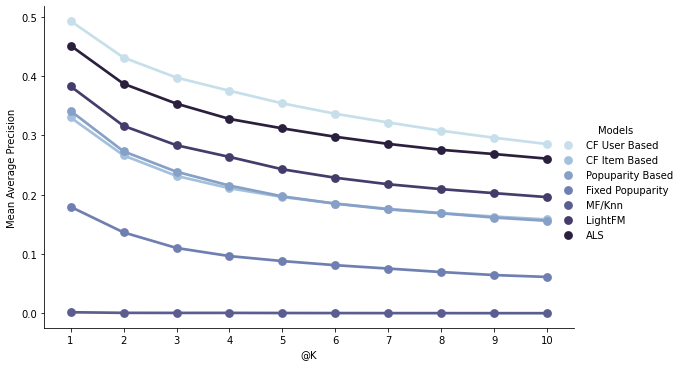

In [ ]:
df_map = eval_map.melt('@K',
                       var_name='Models',
                       value_name='Mean Average Precision')
plot_map = sns.catplot(x='@K',
                       y='Mean Average Precision',
                       hue='Models',
                       data=df_map,
                       kind='point',
                       palette='ch:s=.25,rot=-.25', 
                       height=5,
                       aspect=8/5,
                       legend_out = True)
# replace labels
labels = ['CF User Based', 'CF Item Based', 'Popuparity Based', 
          'Fixed Popuparity', 'MF/Knn', 'LightFM', 'ALS']
for t, l in zip(plot_map._legend.texts, labels): t.set_text(l)

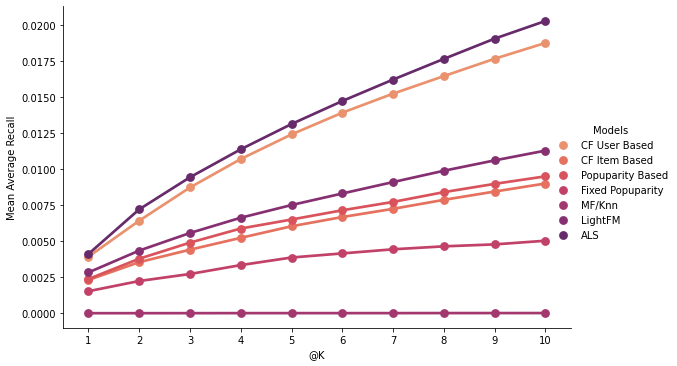

In [ ]:
df_mar = eval_mar.melt('@K', 
                       var_name='Models', 
                       value_name='Mean Average Recall')
plot_mar = sns.catplot(x='@K', 
                       y='Mean Average Recall', 
                       hue='Models', 
                       data=df_mar, 
                       kind='point', 
                       palette='flare', 
                       height=5, 
                       aspect=8/5, 
                       legend_out = True)
# replace labels
labels = ['CF User Based', 'CF Item Based', 'Popuparity Based', 
          'Fixed Popuparity', 'MF/Knn', 'LightFM', 'ALS']
for t, l in zip(plot_mar._legend.texts, labels): t.set_text(l)

### Personalization & Coverage

In [ ]:
from typing import List

def prediction_coverage(predicted: List[list], total_number: int) -> float:
    """
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(total_number * 1.0)*100, 4)
    return prediction_coverage

In [ ]:
# Personalization
cf_user_personalization = recmetrics.personalization(cf_user_predictions)
cf_item_personalization = recmetrics.personalization(cf_item_predictions)
pop_personalization = recmetrics.personalization(pop_predictions)
fix_personalization = recmetrics.personalization(fix_predictions)
knn_personalization = recmetrics.personalization(knn_predictions)
lightfm_personalization = recmetrics.personalization(lightfm_predictions)
als_personalization = recmetrics.personalization(als_predictions)

In [ ]:
# Prediction Coverage
number_of_artists_total = 58813 # from df_final
number_of_artists_train = 10335 # from df_final

cf_user_coverage = prediction_coverage(cf_user_predictions, number_of_artists_total)
cf_item_coverage = prediction_coverage(cf_item_predictions, number_of_artists_total)
pop_coverage = prediction_coverage(pop_predictions, number_of_artists_total)
fix_coverage = prediction_coverage(fix_predictions, number_of_artists_total)
knn_coverage = prediction_coverage(knn_predictions, number_of_artists_total)
lightfm_coverage = prediction_coverage(lightfm_predictions, number_of_artists_total)
als_coverage = prediction_coverage(als_predictions, number_of_artists_total)

cf_user_coverage_train = prediction_coverage(cf_user_predictions, number_of_artists_train)
cf_item_coverage_train = prediction_coverage(cf_item_predictions, number_of_artists_train)
pop_coverage_train = prediction_coverage(pop_predictions, number_of_artists_train)
fix_coverage_train = prediction_coverage(fix_predictions, number_of_artists_train)
knn_coverage_train = prediction_coverage(knn_predictions, number_of_artists_train)
lightfm_coverage_train = prediction_coverage(lightfm_predictions, number_of_artists_train)
als_coverage_train = prediction_coverage(als_predictions, number_of_artists_train)

In [ ]:
eval_predictions = pd.DataFrame(
    {'Recommender': ['Personalization', 'Prediction Coverage (in %)', 'Prediction Coverage on train set(in %)'],
     'cf_user': [ 
       round(cf_user_personalization, 4), 
       round(cf_user_coverage, 4),
       round(cf_user_coverage_train, 4)
       ],
     'cf_item': [ 
       round(cf_item_personalization, 4), 
       round(cf_item_coverage, 4),
       round(cf_item_coverage_train, 4)
       ],
     'pop': [ 
       round(pop_personalization, 4), 
       round(pop_coverage, 4),
       round(pop_coverage_train, 4)
       ],
     'fix': [ 
       round(fix_personalization, 4), 
       round(fix_coverage, 4),
       round(fix_coverage_train, 4)
       ],
     'knn': [ 
       round(knn_personalization, 4), 
       round(knn_coverage, 4),
       round(knn_coverage_train, 4)
       ],
     'lightfm': [ 
       round(lightfm_personalization, 4), 
       round(lightfm_coverage, 4),
       round(lightfm_coverage_train, 4)
       ],
     'als': [ 
       round(als_personalization, 4), 
       round(als_coverage, 4),
       round(als_coverage_train, 4)
       ]
})

eval_predictions

,Recommender,cf_user,cf_item,pop,fix,knn,lightfm,als
0,Personalization,0.7512,0.6086,0.4493,0.0000,0.1653,0.8485,0.9798
1,Prediction Coverage (in %),0.5509,1.2871,0.0765,0.0170,0.6835,0.7532,3.1813
2,Prediction Coverage on train set(in %),3.1350,7.3246,0.4354,0.0968,3.8897,4.2864,18.1035


## nDCG

In [ ]:
#sum the ndcg of each user to get the mean
score=[]
for i in range(len(test)):
  ndcg=ndcg_score([test.cf_user_true_freq.values[i]], [test.cf_user_pred_freq.values[i]])
  score.append(ndcg)

ndcg_cf_user = sum(score) / len(score)

In [ ]:
score=[]
for i in range(len(test)):
  ndcg=ndcg_score([test.cf_item_true_freq.values[i]], [test.cf_item_pred_freq.values[i]])
  score.append(ndcg)

ndcg_cf_item = sum(score) / len(score)

In [ ]:
score=[]
for i in range(len(test)):
  ndcg=ndcg_score([test.als_true_score.values[i]], [test.als_score.values[i]])
  score.append(ndcg)

ndcg_als = sum(score) / len(score)

In [ ]:
print('ndcg of cf user: {}'.format(ndcg_cf_user))
print('ndcg of cf item: {}'.format(ndcg_cf_item))
print('ndcg of als: {}'.format(ndcg_als))

ndcg of cf user: 0.5685328027051182
ndcg of cf item: 0.44225017954028395
ndcg of als: 0.5406209273794709


In [ ]:
df_ndcg = pd.DataFrame({
    'Model':['CF User Based', 'CF Item Based', 'ALS'],
    'nDCG Score':[ndcg_cf_user, ndcg_cf_item, ndcg_als]
})

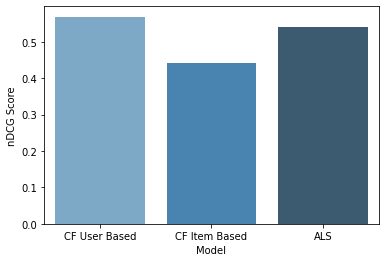

In [ ]:
sns.barplot(x='Model', y='nDCG Score', data=df_ndcg,
                 palette="Blues_d")